In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
from keras.utils.vis_utils import plot_model

Download the caltech_birds2010 dataset

In [ ]:
dataset, info = tfds.load('CaltechBirds2010:0.*.*', with_info=True)

# **U_NET:**

# Preprocessing data


In [3]:
info

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
image_size = 256

In [5]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Data augmentation:**


In [36]:
@tf.function
def load_image_train(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_image = tf.image.flip_up_down(input_image)
    input_image = tf.image.adjust_brightness(input_image,0.5)
    input_image = tf.image.central_crop(input_image,0.5)
    input_image = tf.image.resize_with_crop_or_pad(input_image,image_size,image_size)

    input_mask = tf.image.flip_left_right(input_mask)
    input_mask = tf.image.flip_up_down(input_mask)
    input_mask = tf.image.adjust_brightness(input_mask,0.5)
    input_mask = tf.image.central_crop(input_mask,0.5)
    input_mask = tf.image.resize_with_crop_or_pad(input_mask,image_size,image_size)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [37]:
def load_image_test(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [38]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [39]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

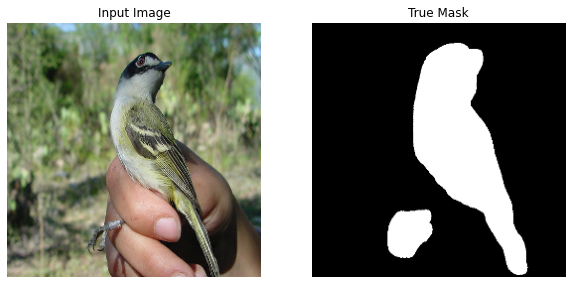

In [46]:
for image, mask in train.take(6):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

# U-net architecture

Encoder | Bottleneck | Decoder
--- | --- | ---
START:| | TS(1,4,2)
CL(32,4,2) |  | TBR(32,4,2)
CBL(64,4,2) |  | TBDR(64,4,2)
CBL(128,4,2) |  | TBR(128,4,2)
CBL(256,4,2) |  | TBDR(256,4,2)
CBL(512,4,2) | CR(512,4,2) | TBDR(512,4,2)


 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.1.5), D=dropout, R=relu,
T=transpose convolution, S=sigmoid. 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02


In [ ]:
# define an U_Net

ri = keras.initializers.RandomNormal(mean=0,stddev=0.02)

inputs = Input(shape=(image_size,image_size,3))
e1 = Conv2D(32,4,2,padding='same',kernel_initializer=ri)(inputs)
e1 = LeakyReLU(0.15)(e1)

e2 = Conv2D(64,4,2,padding='same',kernel_initializer=ri)(e1)
e2 = BatchNormalization()(e2)
e2 = LeakyReLU(0.15)(e2)

e3 = Conv2D(128,4,2,padding='same',kernel_initializer=ri)(e2)
e3 = BatchNormalization()(e3)
e3 = LeakyReLU(0.15)(e3)

e4 = Conv2D(256,4,2,padding='same',kernel_initializer=ri)(e3)
e4 = BatchNormalization()(e4)
e4 = LeakyReLU(0.15)(e4)

e5 = Conv2D(512,4,2,padding='same',kernel_initializer=ri)(e4)
e5 = BatchNormalization()(e5)
e5 = LeakyReLU(0.15)(e5)

b = Conv2D(512,4,2,padding='same',activation='relu',kernel_initializer=ri)(e5)

d5 = Conv2DTranspose(512,4,2,padding='same',kernel_initializer=ri)(b)
d5 = BatchNormalization()(d5)
d5 = Dropout(0.5)(d5)
d5 = Concatenate()([e5,d5])
d5 = ReLU()(d5)

d4 = Conv2DTranspose(256,4,2,padding='same',kernel_initializer=ri)(d5)
d4 = BatchNormalization()(d4)
d4 = Dropout(0.5)(d4)
d4 = Concatenate()([e4,d4])
d4 = ReLU()(d4)

d3 = Conv2DTranspose(128,4,2,padding='same',kernel_initializer=ri)(d4)
d3 = BatchNormalization()(d3)
d3 = Concatenate()([e3,d3])
d3 = ReLU()(d3)

d2 = Conv2DTranspose(64,4,2,padding='same',kernel_initializer=ri)(d3)
d2 = BatchNormalization()(d2)
d2 = Dropout(0.5)(d2)
d2 = Concatenate()([e2,d2])
d2 = ReLU()(d2)

d1 = Conv2DTranspose(32,4,2,padding='same',kernel_initializer=ri)(d2)
d1 = BatchNormalization()(d1)
d1 = Concatenate()([e1,d1])
d1 = ReLU()(d1)

outputs = Conv2DTranspose(1,4,2,padding='same',activation='sigmoid',kernel_initializer=ri)(d1)
Unet = keras.models.Model(inputs,outputs)
Unet.summary()

In [ ]:
plot_model(Unet,show_shapes=True,dpi=60)

# Compile:

Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy

Set accuracy for metrics 

In [49]:
#Compile
optimizer = keras.optimizers.Adam(0.001)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
Unet.compile(optimizer='adam',loss=loss,metrics=['accuracy'])

# Fit the model

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

history = Unet.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_dataset)

# Predict


In [51]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = Unet.predict(image) 
      display([image[0], mask[0], pred_mask[0]])

In [ ]:
show_predictions(test_dataset)